# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [1]:
SEED=202
BASE_DIR='/src/Udacity_Traffic-Sign-Classifier-P2/traffic-signs-data'
OUT_DIR ='/src/Udacity_Traffic-Sign-Classifier-P2/traffic-signs-classification'

# standard libs
import pickle
import csv
from timeit import default_timer as timer
import os
import sys


#visualisation
%matplotlib inline

import matplotlib.pyplot as plt 
from IPython.display import Image
from IPython.display import display

# numerical libs 
import cv2
import math

import random
import numpy as np
random.seed(SEED)
np.random.seed(SEED)

import tensorflow as tf
tf.set_random_seed(SEED)

from tensorflow.python.training import moving_averages
from tensorflow.contrib.framework import add_model_variable
sess = tf.InteractiveSession()

---
## Step 0: Load The Data

In [2]:
# Load pickled data  
# TODO: Fill this in based on where you saved the training and testing data

def load_data(): 
    training_file  = BASE_DIR + '/train.p'
    testing_file   = BASE_DIR + '/test.p'
    classname_file = BASE_DIR + '/signnames.csv'

    classnames = []
    with open(classname_file) as _f:
        rows = csv.reader(_f, delimiter=',')
        next(rows, None)  # skip the headers
        for i, row in enumerate(rows):
            assert(i==int(row[0]))
            classnames.append(row[1])
 
    with open(training_file, mode='rb') as f:
        train = pickle.load(f)
    with open(testing_file, mode='rb') as f:
        test = pickle.load(f)

    X_train, y_train = train['features'], train['labels']
    X_test, y_test   = test['features'], test['labels']
    
    
    X_train  = X_train.astype(np.float32)
    y_train  = y_train.astype(np.int32)
    X_test   = X_test.astype(np.float32)
    y_test   = y_test.astype(np.int32)
    
    return  classnames, X_train, y_train, X_test, y_test

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
### Replace each question mark with the appropriate value.

classnames, X_train, y_train, X_test, y_test = load_data() 
 
# TODO: Number of training examples 
num_train = len(X_train)

# TODO: Number of testing examples.
num_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
_, height, width, channel = X_train.shape
image_shape = (height, width, channel)

# TODO: How many unique classes/labels there are in the dataset.
num_class = len(np.unique(y_train))


print("Number of training examples =", num_train )
print("Number of testing examples =", num_test )
print("Image data shape =", image_shape)
print("Number of classes =", num_class)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

In [4]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.


#help function to draw graph,etc  
def get_label_image(c): 
    img=cv2.imread(BASE_DIR+'/signnames_all.jpg',1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    H, W, _ = img.shape
    dH = H/7.
    dW = W/7.105
    y = c//7
    x = c%7 
    label_image = img[round(y*dH):round(y*dH+dH), round(x*dW):round(x*dW+dW),:]
    label_image = cv2.resize(label_image, (0,0), fx=32./dW, fy=32./dH,)
    return label_image


def insert_subimage(image, sub_image, y, x): 
    h, w, c = sub_image.shape
    image[y:y+h, x:x+w, :]=sub_image 
    return image



** training data summary **
	1st column: label(image)
	2nd column: mean image
	other column: example images
	black text: label
	blue text: sanple count for each class and histogram plot


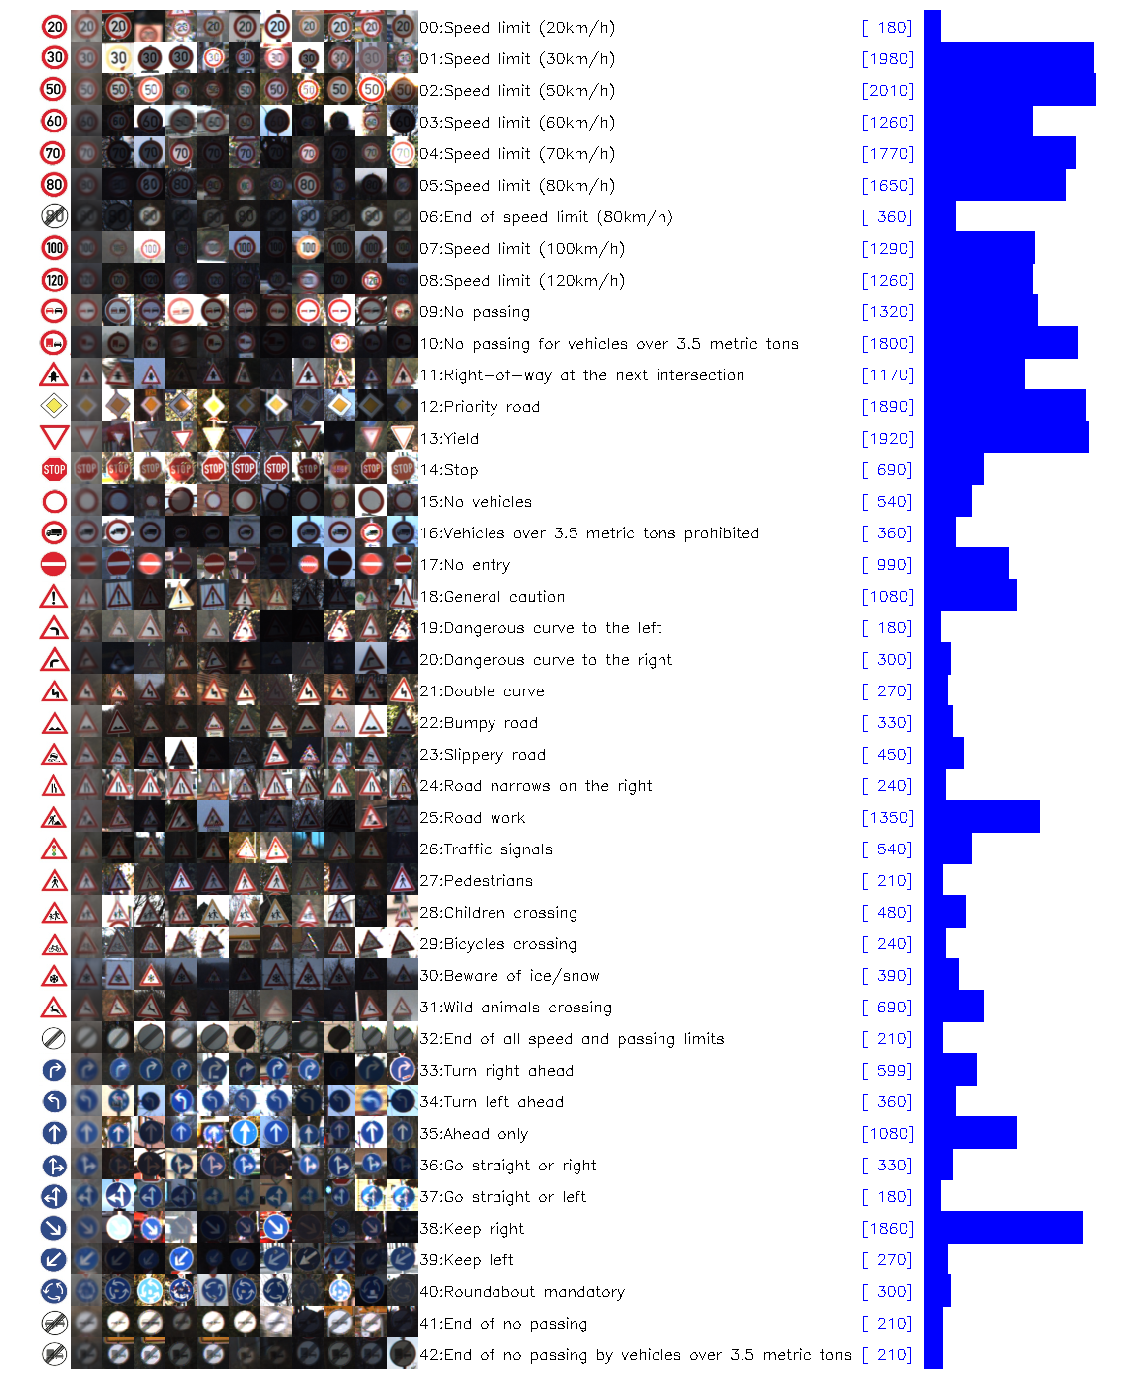

In [5]:
train_images, train_labels = X_train, y_train
 
#count
#h = np.histogram(train_labels, bins=np.arange(num_class))

#results image
num_sample=10
results_image = 255.*np.ones(shape=(num_class*height,(num_sample+2+22)*width, channel),dtype=np.float32)
for c in range(num_class):
    label_image = get_label_image(c)
    insert_subimage(results_image, label_image, c*height, 0)

    #make mean
    idx = list(np.where(train_labels== c)[0])
    mean_image = np.average(train_images[idx], axis=0)
    insert_subimage(results_image, mean_image, c*height, width)

    # imshow('mean_image',mean_image)
    # imshow('label_image',label_image)
    # cv2.waitKey(0)

    #make random sample
    for n in range(num_sample):
        sample_image = train_images[np.random.choice(idx)]
        insert_subimage(results_image, sample_image, c*height, (2+n)*width)

    #print summary
    count=len(idx)
    percentage = float(count)/float(len(train_images))
    cv2.putText(results_image, '%02d:%-6s'%(c, classnames[c]), ((2+num_sample)*width, int((c+0.7)*height)),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,0),1)
    cv2.putText(results_image, '[%4d]'%(count), ((2+num_sample+14)*width, int((c+0.7)*height)),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255),1)
    cv2.rectangle(results_image,((2+num_sample+16)*width, c*height),((2+num_sample+16)*width + round(percentage*3000), (c+1)*height),(0,0,255),-1)

 
cv2.imwrite(BASE_DIR+'/data_summary.jpg',cv2.cvtColor(results_image, cv2.COLOR_BGR2RGB))
#imshow('results_image',results_image)
#cv2.waitKey(0)


print('** training data summary **')
print('\t1st column: label(image)')
print('\t2nd column: mean image')
print('\tother column: example images')
print('\tblack text: label')
print('\tblue text: sanple count for each class and histogram plot')
plt.rcParams["figure.figsize"] = (25,25)
plt.imshow(results_image.astype(np.uint8))
plt.axis('off') 
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [6]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

# split into train and validation. 
def split_data(X_train, y_train, num_valid=3000): 
    # num_valid = num of validation samples
     
    num   = len(y_train)   # 39209 
    index = list(range(num))
    random.shuffle(index)
    train_index=index[num_valid:]
    valid_index=index[:num_valid]


    train_images = X_train[train_index] 
    train_labels = y_train[train_index]
    valid_images = X_train[valid_index] 
    valid_labels = y_train[valid_index] 
   
    return  train_images, train_labels,  valid_images, valid_labels

 



In [7]:
#this expand the train data by flipping.
#  Note: this code is from : http://navoshta.com/traffic-signs-classification/ !!!!!!!!!!!!!!
#  This is the only code *not* from me.
def extend_data_by_flipping(images, labels):

    X=images
    y=labels

    # Classes of signs that, when flipped horizontally, should still be classified as the same class
    self_flippable_horizontally = np.array([11, 12, 13, 15, 17, 18, 22, 26, 30, 35])
    # Classes of signs that, when flipped vertically, should still be classified as the same class
    self_flippable_vertically = np.array([1, 5, 12, 15, 17])
    # Classes of signs that, when flipped horizontally and then vertically, should still be classified as the same class
    self_flippable_both = np.array([32, 40])
    # Classes of signs that, when flipped horizontally, would still be meaningful, but should be classified as some other class
    cross_flippable = np.array([
        [19, 20],
        [33, 34],
        [36, 37],
        [38, 39],
        [20, 19],
        [34, 33],
        [37, 36],
        [39, 38],
    ])
    num_classes = 43

    X_extended = np.empty([0, X.shape[1], X.shape[2], X.shape[3]], dtype=np.float32)
    y_extended = np.empty([0], dtype=np.int32)

    for c in range(num_classes):
        # First copy existing data for this class
        X_extended = np.append(X_extended, X[y == c], axis=0)
        # If we can flip images of this class horizontally and they would still belong to said class...
        if c in self_flippable_horizontally:
            # ...Copy their flipped versions into extended array.
            X_extended = np.append(X_extended, X[y == c][:, :, ::-1, :], axis=0)
        # If we can flip images of this class horizontally and they would belong to other class...
        if c in cross_flippable[:, 0]:
            # ...Copy flipped images of that other class to the extended array.
            flip_class = cross_flippable[cross_flippable[:, 0] == c][0][1]
            X_extended = np.append(X_extended, X[y == flip_class][:, :, ::-1, :], axis=0)
        # Fill labels for added images set to current class.
        y_extended = np.append(y_extended, np.full((X_extended.shape[0] - y_extended.shape[0]), c, dtype=np.int32))

        # If we can flip images of this class vertically and they would still belong to said class...
        if c in self_flippable_vertically:
            # ...Copy their flipped versions into extended array.
            X_extended = np.append(X_extended, X_extended[y_extended == c][:, ::-1, :, :], axis=0)
        # Fill labels for added images set to current class.
        y_extended = np.append(y_extended, np.full((X_extended.shape[0] - y_extended.shape[0]), c, dtype=np.int32))

        # If we can flip images of this class horizontally AND vertically and they would still belong to said class...
        if c in self_flippable_both:
            # ...Copy their flipped versions into extended array.
            X_extended = np.append(X_extended, X_extended[y_extended == c][:, ::-1, ::-1, :], axis=0)
        # Fill labels for added images set to current class.
        y_extended = np.append(y_extended, np.full((X_extended.shape[0] - y_extended.shape[0]), c, dtype=np.int32))

    extend_datas  = X_extended
    extend_labels = y_extended
    return (extend_datas, extend_labels)

In [8]:
# use opencv to do data agumentation
# see also: https://github.com/dmlc/mxnet/blob/master/python/mxnet/image.py
def perturb(image, keep, angle_limit=15, scale_limit=0.1, translate_limit=3, distort_limit=3, illumin_limit=0.7):

    u=np.random.uniform()
    if u>keep :
        (W, H, C) = image.shape
        center = np.array([W / 2., H / 2.])
        da = np.random.uniform(low=-1, high=1) * angle_limit/180. * math.pi
        scale = np.random.uniform(low=-1, high=1) * scale_limit + 1

        cc = scale*math.cos(da)
        ss = scale*math.sin(da)
        rotation    = np.array([[cc, ss],[-ss,cc]])
        translation = np.random.uniform(low=-1, high=1, size=(1,2)) * translate_limit
        distort     = np.random.standard_normal(size=(4,2)) * distort_limit

        pts1 = np.array([[0., 0.], [0., H], [W, H], [W, 0.]])
        pts2 = np.matmul(pts1-center, rotation) + center  + translation

        #add perspective noise
        pts2 = pts2 + distort


        #http://milindapro.blogspot.jp/2015/05/opencv-filters-copymakeborder.html
        matrix  = cv2.getPerspectiveTransform(pts1.astype(np.float32), pts2.astype(np.float32)) 
        perturb = cv2.warpPerspective(image, matrix, (W, H), flags=cv2.INTER_LINEAR,
                                      borderMode=cv2.BORDER_REFLECT_101)  # BORDER_WRAP  #BORDER_REFLECT_101  #cv2.BORDER_CONSTANT  BORDER_REPLICATE

        #brightness, contrast, saturation-------------
        #from mxnet code
        if 1:  #brightness
            alpha = 1.0 + illumin_limit*random.uniform(-1, 1)
            perturb *= alpha
            perturb = np.clip(perturb,0.,255.)
            pass

        if 1:  #contrast
            coef = np.array([[[0.299, 0.587, 0.114]]]) #rgb to gray (YCbCr) :  Y = 0.299R + 0.587G + 0.114B

            alpha = 1.0 + illumin_limit*random.uniform(-1, 1)
            gray = perturb * coef
            gray = (3.0 * (1.0 - alpha) / gray.size) * np.sum(gray)
            perturb *= alpha
            perturb += gray
            perturb = np.clip(perturb,0.,255.)
            pass

        if 1:  #saturation
            coef = np.array([[[0.299, 0.587, 0.114]]]) #rgb to gray (YCbCr) :  Y = 0.299R + 0.587G + 0.114B

            alpha = 1.0 + illumin_limit*random.uniform(-1, 1)
            gray = perturb * coef
            gray = np.sum(gray, axis=2, keepdims=True)
            gray *= (1.0 - alpha)
            perturb *= alpha
            perturb += gray
            perturb = np.clip(perturb,0.,255.)
            pass

        return perturb

    else:
        return image
    
    
def make_perturb_images(images, keep ):
    arguments = np.zeros(images.shape)
    for n in range(len(images)):
        arguments[n] = perturb(images[n],keep = keep)

    return arguments


# sample and shuffle the data such that each class has equal number of samples for training
def shuffle_data_uniform(datas, labels, num_class, num_per_class=None):

    if num_per_class is None:
        max_count = 0
        for c in range(num_class):
            idx = list(np.where(labels == c)[0])
            count = len(idx)
            max_count = max(count, max_count)
        num_per_class = max_count

    index = []
    for c in range(num_class):
        idx = list(np.where(labels == c)[0])
        index = index + list(np.random.choice(idx, num_per_class))

    random.shuffle(index)
    shuffle_datas  = datas[index]
    shuffle_labels = labels[index]

    return shuffle_datas, shuffle_labels

#generate next batch for sdg
def generate_train_batch_next(datas, labels, n, batch_size):
    i = n*batch_size
    batch_datas  = datas [i:i+batch_size]
    batch_labels = labels[i:i+batch_size]
    return batch_datas, batch_labels

** some data setting **
	height, width, channel = 32, 32, 3
	num_test  = 12630
	num_valid = 3000
	num_train = 31799

	num_train (after flip)= 54644
	num_argument = 860000


examples of argument images (first column is orginal)


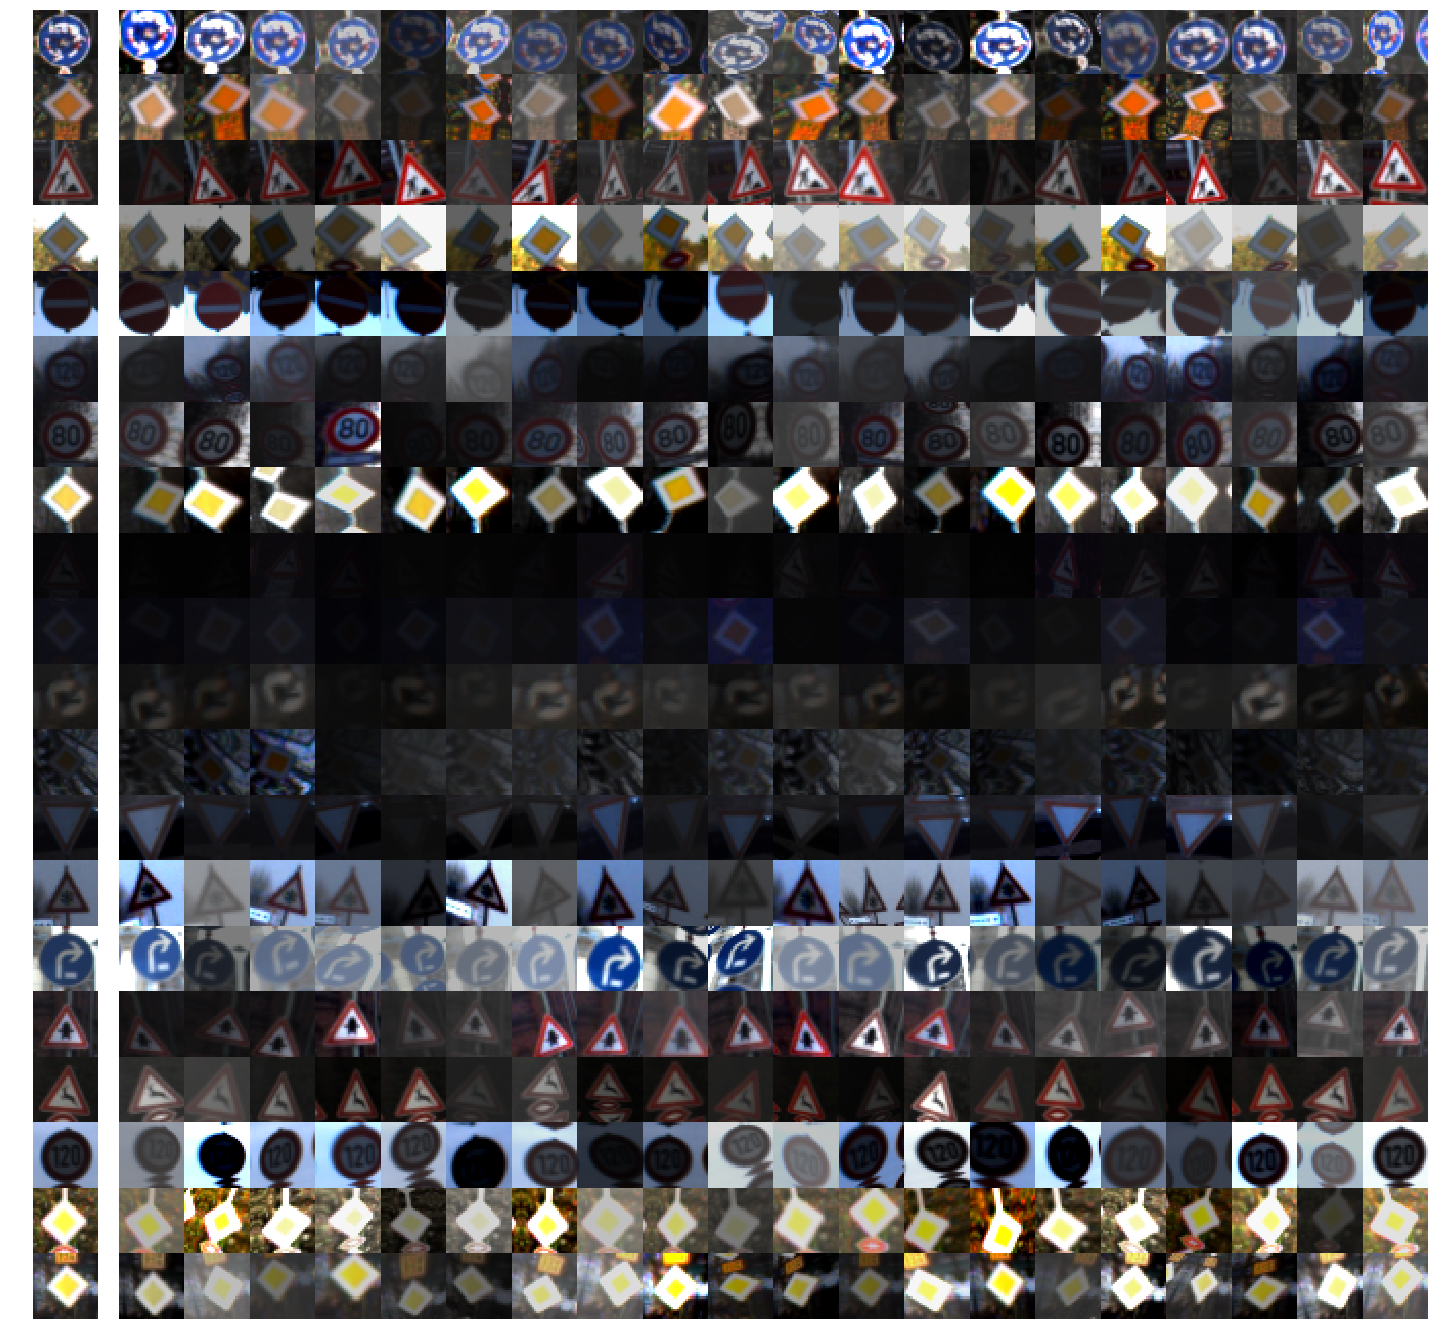

In [9]:
#prepare all data here 
classnames, X_train, y_train, X_test, y_test = load_data() 

train_images, train_labels,  valid_images, valid_labels = split_data(X_train, y_train)
test_images, test_labels = X_test, y_test
 
num_train = len(train_images)
num_valid = len(valid_images)
num_test  = len(test_images)
    
print('** some data setting **')
print('\theight, width, channel = %d, %d, %d'%(height, width, channel))
print('\tnum_test  = %d'%num_test)
print('\tnum_valid = %d'%num_valid)
print('\tnum_train = %d'%num_train)

#train data filpping.
train_images, train_labels = extend_data_by_flipping(train_images, train_labels) 
num_train_flip = len(train_images)
print('')
print('\tnum_train (after flip)= %d' % num_train_flip )
 
#train data augmentation 
keep = 0.20   # 0.50   0.25 0.20   #0.15
num_per_class = 20000
num_argument = num_per_class*num_class
#argument_images, argument_labels = shuffle_data_uniform(train_images, train_labels, num_class, num_per_class=num_per_class)
#argument_images = make_perturb_images(argument_images, keep=keep) 
#num_argument = len(argument_images) 
print('\tnum_argument = %d' % num_argument)  
 
    
    
#example of new generated train data -------------------------------------------- 
print('\n')
print('examples of argument images (first column is orginal)')
 

# results image
num_sample = 20
perturbance_per_sample = 20

results_image = 255. * np.ones(shape=(num_sample * height, (perturbance_per_sample+1)* width+10, channel),dtype=np.float32)

for j in range(num_sample):
    i = random.randint(0, num_train_flip - 1)

    image = train_images[i]
    insert_subimage(results_image, image, j * height, 0)

    for k in range(0, perturbance_per_sample):
        perturb_image = perturb(image, keep=0)
        insert_subimage(results_image, perturb_image, j*height, (k+1)*width+10)

         
cv2.imwrite(BASE_DIR+'/data_argument.jpg',cv2.cvtColor(results_image, cv2.COLOR_BGR2RGB))
plt.rcParams["figure.figsize"] = (25,25)
plt.imshow(results_image.astype(np.uint8))
plt.axis('off') 
plt.show()
    

### Model Architecture

In [10]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

# we define the basic ops first -----------------------------------------

##  global varaiables ##
IS_TRAIN_PHASE = tf.placeholder(dtype=tf.bool, name='is_train_phase')

def conv2d(input, num_kernels=1, kernel_size=(1,1), stride=[1,1,1,1], padding='SAME', has_bias=True, name='conv'):

    input_shape = input.get_shape().as_list()
    assert len(input_shape)==4
    C = input_shape[3]
    H = kernel_size[0]
    W = kernel_size[1]
    K = num_kernels

    ##[filter_height, filter_width, in_channels, out_channels]
    w    = tf.get_variable(name=name+'_weight', shape=[H, W, C, K], initializer=tf.truncated_normal_initializer(stddev=0.1))
    conv = tf.nn.conv2d(input, w, strides=stride, padding=padding, name=name)
    if has_bias:
        b = tf.get_variable(name=name + '_bias', shape=[K], initializer=tf.constant_initializer(0.0))
        conv = conv+b

    return conv


def relu(input, name='relu'):
    act = tf.nn.relu(input, name=name)
    return act

def prelu(input, name='prelu'):
  alpha = tf.get_variable(name=name+'_alpha', shape=input.get_shape()[-1],
                       #initializer=tf.constant_initializer(0.25),
                        initializer=tf.random_uniform_initializer(minval=0.1, maxval=0.3),
                        dtype=tf.float32)
  pos = tf.nn.relu(input)
  neg = alpha * (input - abs(input)) * 0.5

  return pos + neg


# very leaky relu
def vlrelu(input, alpha=0.25, name='vlrelu'): #  alpha between 0.1 to 0.5
    act =tf.maximum(alpha*input,input)
    return act

def maxpool(input, kernel_size=(1,1), stride=[1,1,1,1], padding='SAME', has_bias=True, name='max' ):
    H = kernel_size[0]
    W = kernel_size[1]
    pool = tf.nn.max_pool(input, ksize=[1, H, W, 1], strides=stride, padding=padding, name=name)
    return pool

def avgpool(input, kernel_size=(1,1), stride=[1,1,1,1], padding='SAME', has_bias=True, is_global_pool=False, name='avg'):

    if is_global_pool==True:
        input_shape = input.get_shape().as_list()
        assert len(input_shape) == 4
        H = input_shape[1]
        W = input_shape[2]

        pool = tf.nn.avg_pool(input, ksize=[1, H, W, 1], strides=[1,H,W,1], padding='VALID', name=name)
        pool = flatten(pool)

    else:
        H = kernel_size[0]
        W = kernel_size[1]
        pool = tf.nn.avg_pool(input, ksize=[1, H, W, 1], strides=stride, padding=padding, name=name)

    return pool


def dropout(input, keep=1.0, name='drop'):
    #drop = tf.cond(IS_TRAIN_PHASE, lambda: tf.nn.dropout(input, keep), lambda: input)
    drop = tf.cond(IS_TRAIN_PHASE,
                   lambda: tf.nn.dropout(input, keep),
                   lambda: tf.nn.dropout(input, 1))
    return drop


def flatten(input, name='flat'):
    input_shape = input.get_shape().as_list()        # list: [None, 9, 2]
    dim   = np.prod(input_shape[1:])                 # dim = prod(9,2) = 18
    flat  = tf.reshape(input, [-1, dim], name=name)  # -1 means "all"
    return flat

def concat(input, name='cat'):
    cat = tf.concat(concat_dim=3, values=input, name=name)
    return cat


#https://github.com/tensorflow/tensorflow/blob/master/tensorflow/g3doc/api_docs/python/functions_and_classes/shard4/tf.contrib.layers.batch_norm.md
#http://www.bubufx.com/detail-1792794.html
def bn (input, decay=0.9, eps=1e-5, name='bn'):
    with tf.variable_scope(name) as scope:
        bn = tf.cond(IS_TRAIN_PHASE,
            lambda: tf.contrib.layers.batch_norm(input,  decay=decay, epsilon=eps, center=True, scale=True,
                              is_training=1,reuse=None,
                              updates_collections=None, scope=scope),
            lambda: tf.contrib.layers.batch_norm(input, decay=decay, epsilon=eps, center=True, scale=True,
                              is_training=0, reuse=True,
                              updates_collections=None, scope=scope))

    return bn

In [11]:
# basic building blocks

def conv2d_bn_relu(input, num_kernels=1, kernel_size=(1,1), stride=[1,1,1,1], padding='SAME', name='conv'):
    with tf.variable_scope(name) as scope:
        block = conv2d(input, num_kernels=num_kernels, kernel_size=kernel_size, stride=stride, padding=padding, has_bias=False)
        block = bn(block)
        block = relu(block)
    return block


def bn_relu_conv2d (input, num_kernels=1, kernel_size=(1, 1), stride=[1, 1, 1, 1], padding='SAME', name='conv'):
    with tf.variable_scope(name) as scope:
        block = bn(input)
        block = relu(block)
        block = conv2d(block, num_kernels=num_kernels, kernel_size=kernel_size, stride=stride, padding=padding, has_bias=False)
    return block



# modified dense block from the paper [1] "Densely Connected Convolutional Networks" - Gao Huang, Zhuang Liu, Kilian Q. Weinberger, 
# Laurens van der Maaten, Arxiv 2016
# Modification: 
#   1. the paper uses bn-relu-conv but we use conv-bn-relu
#   2. the paper uses dropout inside the block but we shift the dropout outside the block see network construction later
def dense_block_cbr (input, num=1, num_kernels=1, kernel_size=(1, 1), drop=None, name='DENSE'):
 
    block = input
    for n in  range(num):
        with tf.variable_scope(name+'_%d'%n) as scope:
            conv = conv2d(block, num_kernels=num_kernels, kernel_size=kernel_size, stride=[1,1,1,1], padding='SAME', has_bias=False)
            conv = bn(conv)
            conv = relu(conv)

            if drop is not None:
                keep = (1 - drop) ** (1. / num)
                conv = dropout(conv, keep=keep)

            block = concat((block, conv))
    return block

In [12]:
# the loss 
def l2_regulariser(decay):

    variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    for v in variables:
        name = v.name
        if 'weight' in name:  #this is weight
            l2 = decay * tf.nn.l2_loss(v)
            tf.add_to_collection('losses', l2)
        elif 'bias' in name:  #this is bias
            pass
        elif 'beta' in name:
            pass
        elif 'gamma' in name:
            pass
        elif 'moving_mean' in name:
            pass
        elif 'moving_variance' in name:
            pass
        elif 'moments' in name:
            pass

        else:
            #pass
            #raise Exception('unknown variable type: %s ?'%name)
            pass

    l2_loss = tf.add_n(tf.get_collection('losses'))
    return l2_loss


def cross_entropy(logit, label, name='cross_entropy'):
    label = tf.cast(label, tf.int64)
    cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logit, label), name=name)
    return cross_entropy


def accuracy(prob, label, name='accuracy'):
    correct_prediction = tf.equal(tf.argmax(prob, 1), tf.cast(label, tf.int64))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name=name)
    return accuracy


In [13]:
# my densenet here!
#the inference part (without loss)

def DenseNet_3( input_shape=(1,1,1), output_shape = (1)):

    H, W, C   = input_shape
    num_class = output_shape
    input     = tf.placeholder(shape=[None, H, W, C], dtype=tf.float32, name='input')

    #color preprocessing using conv net:
    #see "Systematic evaluation of CNN advances on the ImageNet"-Dmytro Mishkin, Nikolay Sergievskiy, Jiri Matas, ARXIV 2016
    # https://arxiv.org/abs/1606.02228
    # we use learnable prelu (different from paper) and 3x3 onv
    with tf.variable_scope('preprocess') as scope:
        input = bn(input, name='b1')
        input = conv2d(input, num_kernels=8, kernel_size=(3, 3), stride=[1, 1, 1, 1], padding='SAME', has_bias=True, name='c1')
        input = prelu(input, name='r1')
        input = conv2d(input, num_kernels=8, kernel_size=(1, 1), stride=[1, 1, 1, 1], padding='SAME', has_bias=True, name='c2')
        input = prelu(input, name='r2')


    with tf.variable_scope('block1') as scope:
        block1 = conv2d_bn_relu(input, num_kernels=32, kernel_size=(5, 5), stride=[1, 1, 1, 1], padding='SAME')
        block1 = maxpool(block1, kernel_size=(2,2), stride=[1, 2, 2, 1], padding='SAME')

    # we use conv-bn-relu in DENSE block (different from paper)
    # dropout is taken out of the block
    with tf.variable_scope('block2') as scope:
        block2 = dense_block_cbr(block1, num=4, num_kernels=16, kernel_size=(3, 3), drop=None)
        block2 = maxpool(block2, kernel_size=(2, 2), stride=[1, 2, 2, 1], padding='SAME')

    with tf.variable_scope('block3') as scope:
        block3 = dense_block_cbr(block2, num=4, num_kernels=24, kernel_size=(3, 3), drop=None)
        block3 = dropout(block3, keep=0.9)
        block3 = maxpool(block3,  kernel_size=(2,2), stride=[1, 2, 2, 1], padding='SAME')

    with tf.variable_scope('block4') as scope:
        block4 = dense_block_cbr(block3, num=4, num_kernels=32, kernel_size=(3, 3), drop=None)
        block4 = conv2d_bn_relu(block4, num_kernels=num_class, kernel_size=(1,1), stride=[1, 1, 1, 1], padding='SAME')
        block4 = dropout(block4, keep=0.8)
        block4 = avgpool(block4, is_global_pool=True)


    logit = block4
    return logit

In [14]:


# construct the graph here
make_net = DenseNet_3  #LeNet_0  #LeNet_1

logit  = make_net(input_shape =(height, width, channel), output_shape=(num_class))
data   = tf.get_default_graph().get_tensor_by_name('input:0')
label  = tf.placeholder(dtype=tf.int32, shape=[None])
prob   = tf.nn.softmax(logit)

l2     = l2_regulariser(decay=0.0005)
loss   = cross_entropy(logit, label)
metric = accuracy(prob, label)



### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [15]:
### Train your model here.
### Feel free to use as many code cells as needed.

# changing of learning rate
def schdule_by_step( r, steps=(0,100), items=(0.1,0.01)):

    item = items[0]
    N=len(steps)
    for n in range(N):
        if r >= steps[n]:
            item = items[n]
    return item


#for testing and validation
def test_net( datas, labels, batch_size, data, label, loss, metric, sess):

    num = len(datas)
    all_loss = 0
    all_acc = 0
    all = 0
    for n in range(0, num, batch_size):
        #print('\r  evaluating .... %d/%d' % (n, num), end='', flush=True)
        start = n
        end = start+batch_size if start+batch_size<=num else num
        batch_datas  = datas  [start:end]
        batch_labels = labels [start:end]

        fd = {data: batch_datas, label: batch_labels, IS_TRAIN_PHASE : False}
        test_loss, test_acc = sess.run([loss, metric], feed_dict=fd)

        a = end-start
        all += a
        all_loss += a*test_loss
        all_acc  += a*test_acc

    assert(all==num)
    loss = all_loss/all
    acc  = all_acc/all

    return loss, acc

In [20]:
#solver 
epoch_log  = 2 
max_run    = 9
batch_size = 256  #96  384  #128
steps = (0, 3, 6, 8)  
rates = (0.1, 0.01,  0.001, 0.0001) 

learning_rate = tf.placeholder(tf.float32, shape=[])
solver = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9)
solver_step = solver.minimize(loss+l2)



# start training here ------------------------------------------------
print ('start training')
sess.run(tf.global_variables_initializer(), feed_dict = {IS_TRAIN_PHASE : True } )
saver  = tf.train.Saver()
writer = tf.summary.FileWriter(OUT_DIR + '/tf', graph=tf.get_default_graph())


# keep a log   
print('')
print(' run  epoch   iter    rate      |  train_loss    (acc)     |  valid_loss    (acc)     |  time ')
print('----------------------------------------------------------------------------------------------')

tic = timer()
iter = 0
for r in range(max_run):
    rate = schdule_by_step(r, steps=steps, items=rates)

    argument_images, argument_labels = shuffle_data_uniform(train_images, train_labels, num_class,  num_per_class=num_per_class)
    argument_images = make_perturb_images(argument_images, keep=keep)


    num_argument = len(argument_images)
    N = max(num_argument//batch_size-1,1)
    #iter_log = round(float(num_train) / float(num_argument) * float(N))
    iter_log = max(round(float( epoch_log *num_train ) / float(batch_size)),1)
    for n in range(N):
        iter  = iter + 1
        run   = r + float(n)/float(N)
        epoch = float(iter*batch_size)/float(num_train)

        batch_datas, batch_labels = generate_train_batch_next( argument_images, argument_labels, n, batch_size )

        fd = {data: batch_datas, label: batch_labels, learning_rate: rate, IS_TRAIN_PHASE : True }
        _, batch_loss, batch_acc, = sess.run([solver_step, loss, metric ],feed_dict=fd)

      
        print('\r%4.1f  %5.1f   %05d   %f |  %f    (%f)  ' %
                  (run, epoch, iter, rate, batch_loss, batch_acc), end='', flush=True)

        #do validation here!
        if iter%iter_log==0 or (r==max_run-1 and n==N-1): 
            toc = timer()
            sec_pass = toc - tic
            min_pass = sec_pass/60.

            #validation
            val_loss, val_acc =  test_net(valid_images, valid_labels, batch_size, data, label, loss, metric, sess)

            #print('\r')
            print('\r%4.1f  %5.1f   %05d   %f |  %f    (%f) |  %f    (%f) | %4.1f min' %
                  (run, epoch, iter, rate, batch_loss, batch_acc, val_loss, val_acc, min_pass ), end='\n',flush=True)


        pass

    # save intermediate checkpoint
    # saver.save(sess, out_dir + '/check_points/%06d.ckpt'%r)  #iter


#final test! ------------------------------------------
# save final checkpoint
os.makedirs (OUT_DIR + '/check_points/final.ckpt',exist_ok=True)
saver.save(sess, OUT_DIR + '/check_points/final.ckpt')

print('\n') 
print('** evaluation on test set **' )
test_loss, test_acc = test_net(test_images, test_labels, batch_size, data, label, loss, metric, sess)
print('test_loss=%f    (test_acc=%f)' % ( test_loss, test_acc))

start training

 run  epoch   iter    rate      |  train_loss    (acc)     |  valid_loss    (acc)     |  time 
----------------------------------------------------------------------------------------------


MemoryError: 

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

num=5


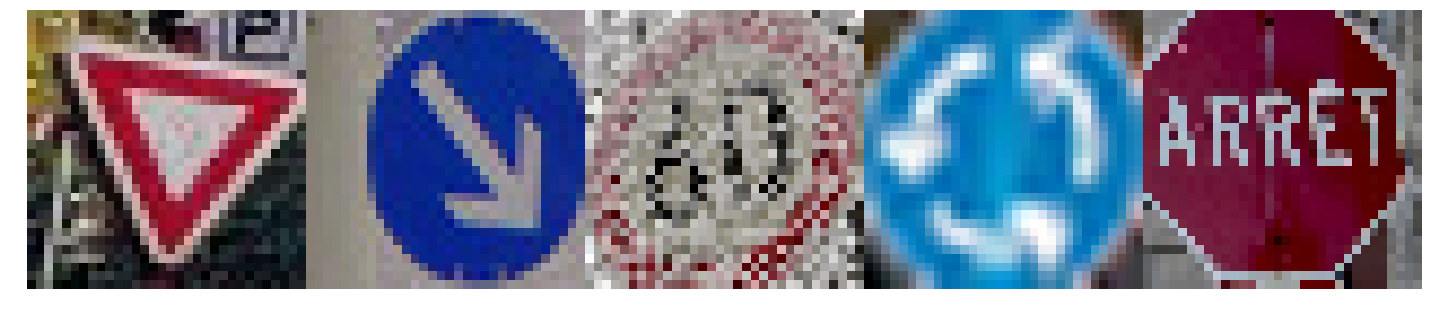

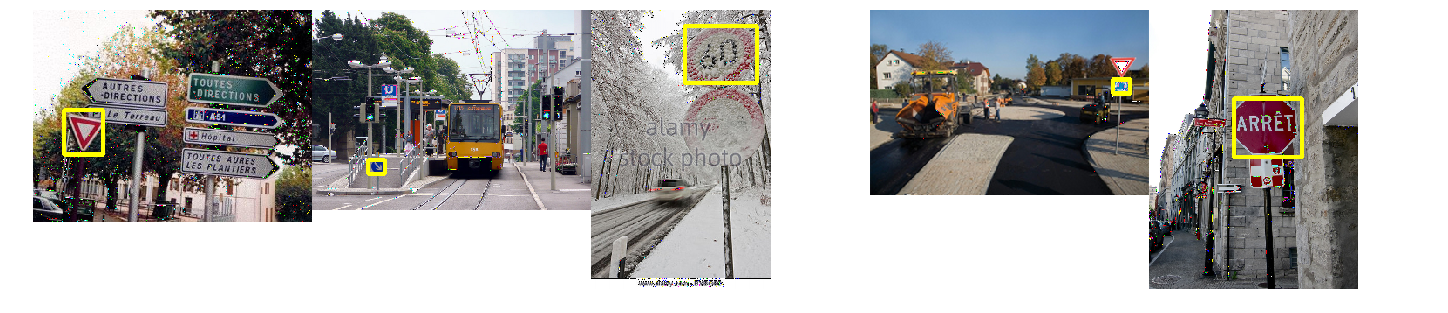

In [22]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

test_files=['0004.jpg',   #normal
            '0000.jpg',   #normal
            '0007.jpg',   #occluded with snow
            '0006.jpg',   #small
            '0005.jpg',   #not in class
            ]
test_rois =[(54,180,125,260),(160,430,207,469),(181,32,321,142),(226,65,242,78 ),(388,408,700,676)]
test_label=[13,38,3,40,14]

num=len(test_files)
print('num=%d'%num)

# crop roi to 32x32 
results_image  = 255. * np.ones(shape=(1 * height, num* width, channel),dtype=np.float32) 
results_image1 = 255. * np.ones(shape=(1 * 320, num* 320, channel),dtype=np.float32)  
crops = np.zeros(shape=(num,height,width,channel),dtype=np.float32)
for n in range(num):
    img = cv2.imread(BASE_DIR+'/extra/' + test_files[n], 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) 
    x1, y1, x2, y2 = test_rois[n] 
    crop = cv2.resize(img[y1:y2, x1:x2, :], (0, 0), fx=32. / (x2 - x1), fy=32. / (y2 - y1),
                      interpolation=cv2.INTER_CUBIC)
    
    crop = np.clip(crop,0,255)
    crops[n]=crop
    insert_subimage(results_image, crop, 0, n*width)

    
    #mak roi and show
    H,W,C=img.shape
    S=max(H,W)
    f=320./S
    norm_img = cv2.resize(img, (0, 0), fx=f, fy=f, interpolation=cv2.INTER_CUBIC)  
    cv2.rectangle(norm_img, (round(f*x1), round(f*y1)), (round(f*x2), round(f*y2)), (255,255,0), 3)
    insert_subimage(results_image1, norm_img, 0, n*320)     
    #cv2.imshow('crop', crop)
    #cv2.imshow('img', img)
    #cv2.waitKey(0)

cv2.imwrite(OUT_DIR+'/extra_crops.jpg',  cv2.cvtColor(results_image, cv2.COLOR_BGR2RGB) )
cv2.imwrite(OUT_DIR+'/extra_marked.jpg', cv2.cvtColor(results_image1, cv2.COLOR_BGR2RGB) )
plt.rcParams["figure.figsize"] = (25,25)
plt.imshow(results_image.astype(np.uint8))
plt.axis('off') 
plt.show()

plt.imshow(results_image1.astype(np.uint8))
plt.axis('off') 
plt.show()

### Predict the Sign Type for Each Image

In [3]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

### Analyze Performance

In [4]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [3]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")